In [4]:
import numpy as np
import cv2
import mahotas
import os
import pickle
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

# ====== User-defined path ======
IMDIR = "C:/Users/prave/Final Year project/data"  # <-- Change this to your real image folder

# Setup save paths
BOVW = "model/bovw_codebook_600.pickle"
DICT_SIZE = 600
DATA = 'model/data_600.npy'
LABEL = 'model/label_600.npy'

# ==== Feature descriptors ====

# Hu Moments
def fd_hu_moments(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    feature = cv2.HuMoments(cv2.moments(gray)).flatten()
    return feature

# Haralick Texture
def fd_haralick(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    haralick = mahotas.features.haralick(gray).mean(axis=0)
    return haralick

# Color Histogram
def fd_histogram(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    bins = 8
    hist = cv2.calcHist([hsv], [0, 1, 2], None, [bins, bins, bins], [0, 256, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()

# SIFT Bag of Visual Words feature extraction
def feature_extract(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    features = bowDiction.compute(gray, sift.detect(gray))
    if features is not None:
        return features.flatten()
    else:
        # If no features detected, return zeros
        return np.zeros(DICT_SIZE)

# ======= Start Processing ========

# Directory containing images
base = Path(IMDIR).resolve()
print(f"Base Directory: {base}")

# Initialize SIFT and BOW trainer
sift = cv2.SIFT_create()
BOW = cv2.BOWKMeansTrainer(DICT_SIZE)

# Build vocabulary (Bag of Words Dictionary)
print("Building vocabulary...")
descriptor_list = []
for file in base.glob('**/*.*'):
    fpath = Path(file).resolve()
    image = cv2.imread(str(fpath))

    if image is None:
        print(f"Warning: Failed to read {fpath}")
        continue

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    kp, des = sift.detectAndCompute(gray, None)

    if des is not None:
        descriptor_list.append(des)
    else:
        print(f"Warning: No descriptors found for {fpath}")

# Stack all descriptors vertically
if len(descriptor_list) == 0:
    print("Error: No descriptors collected. Cannot cluster.")
    exit(1)

descriptors = np.vstack(descriptor_list)
print(f"Total descriptors shape: {descriptors.shape}")

# Add descriptors to BOW trainer and cluster
BOW.add(descriptors)
print("Clustering...")
dictionary = BOW.cluster()
print(f"Dictionary shape: {dictionary.shape}")

# Save the codebook
os.makedirs("model", exist_ok=True)
with open(BOVW, "wb") as f:
    pickle.dump(dictionary, f)
print(f"Codebook saved to {BOVW}")

# Load the codebook again
with open(BOVW, "rb") as f:
    dictionary = pickle.load(f)

# Initialize BOW image descriptor extractor
sift2 = cv2.SIFT_create()
bowDiction = cv2.BOWImgDescriptorExtractor(sift2, cv2.BFMatcher(cv2.NORM_L2))
bowDiction.setVocabulary(dictionary)

# ===== Feature Extraction =====
print("Feature Extraction...")

x_data = []
x_label = []

for file in base.glob('**/*.*'):
    fpath = Path(file).resolve()
    image = cv2.imread(str(fpath))

    if image is None:
        print(f"Warning: Failed to read {fpath}")
        continue

    try:
        Humo = fd_hu_moments(image)
        Harl = fd_haralick(image)
        Hist = fd_histogram(image)
        Bovw = feature_extract(image)

        mfeature = np.hstack([Humo, Harl, Hist, Bovw])
        x_data.append(mfeature)
        x_label.append(int(fpath.parent.name))  # Folder name as label
        print(f"Processed {fpath.name}, feature shape: {mfeature.shape}")

    except Exception as e:
        print(f"Error processing {fpath.name}: {e}")

# ===== Save the final datasets =====

# Scale features
scaler = MinMaxScaler(feature_range=(0, 1))
x_data = scaler.fit_transform(x_data)

# Encode labels
encoder = LabelEncoder()
x_label = encoder.fit_transform(x_label)

# Save the data and labels
np.save(DATA, np.array(x_data))
np.save(LABEL, np.array(x_label))

print(f"Data saved to {DATA}")
print(f"Labels saved to {LABEL}")

print("✅ Completed Successfully!")

'''
Sample Run:
Just run this script. No command line arguments needed.
'''


Base Directory: C:\Users\prave\Final Year project\data
Building vocabulary...
Total descriptors shape: (493256, 128)
Clustering...
Dictionary shape: (600, 128)
Codebook saved to model/bovw_codebook_600.pickle
Feature Extraction...
Processed 301.png, feature shape: (1132,)
Processed 301_cb.png, feature shape: (1132,)
Processed 301_sharp.png, feature shape: (1132,)
Processed 302.png, feature shape: (1132,)
Processed 302_cb.png, feature shape: (1132,)
Processed 302_sharp.png, feature shape: (1132,)
Processed 303.png, feature shape: (1132,)
Processed 303_cb.png, feature shape: (1132,)
Processed 303_sharp.png, feature shape: (1132,)
Processed 304.png, feature shape: (1132,)
Processed 304_cb.png, feature shape: (1132,)
Processed 304_sharp.png, feature shape: (1132,)
Processed 305.png, feature shape: (1132,)
Processed 305_cb.png, feature shape: (1132,)
Processed 305_sharp.png, feature shape: (1132,)
Processed 306.png, feature shape: (1132,)
Processed 306_cb.png, feature shape: (1132,)
Process

'\nSample Run:\nJust run this script. No command line arguments needed.\n'


<==== Model ====>

RandomForestClassifier(n_jobs=-1, random_state=42, verbose=1)

<==== Hyperparameter Search ====>

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    0.0s finished



<==== Best Model ====>

Best Score (Training): 0.9809523809523809
Best Parameters: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 10}

<==== Test Accuracy ====>

Test Accuracy: 0.9857142857142858

<==== Confusion Matrix ====>



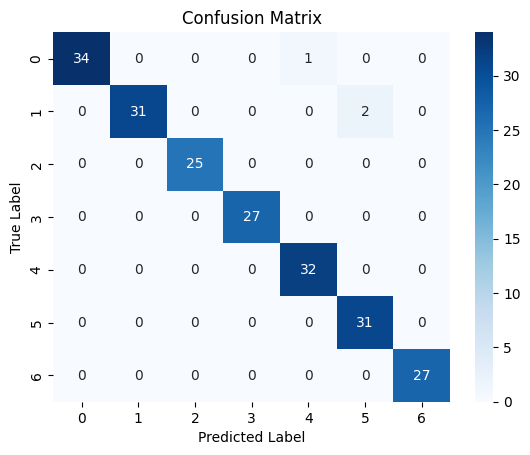


<==== Classification Report ====>

              precision    recall  f1-score   support

           0       1.00      0.97      0.99        35
           1       1.00      0.94      0.97        33
           2       1.00      1.00      1.00        25
           3       1.00      1.00      1.00        27
           4       0.97      1.00      0.98        32
           5       0.94      1.00      0.97        31
           6       1.00      1.00      1.00        27

    accuracy                           0.99       210
   macro avg       0.99      0.99      0.99       210
weighted avg       0.99      0.99      0.99       210


<==== Saving Model ====>

Model saved to model/rf_model.pkl


'\nSample run:\n$ python hyper_train.py\n'

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump, load
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
import os

# Configure file paths
DATA = 'model/data_600.npy'
LABEL = 'model/label_600.npy'
MODEL_PATH = 'model/rf_model.pkl'

# Load data and labels
data = np.load(DATA)
label = np.load(LABEL)

# Split the data
x_train, x_test, y_train, y_test = train_test_split(data, label, test_size=0.20, random_state=42)

# Initialize Random Forest
print("\n<==== Model ====>\n")
clf = RandomForestClassifier(n_jobs=-1, verbose=1, random_state=42)
print(clf)

print("\n<==== Hyperparameter Search ====>\n")

# Define new, optimized hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200, 300],  # Less large estimators
    'max_depth': [10, 15, 20, 25, None],  # More moderate tree depths
    'min_samples_split': [2, 5, 10],  # More common split values
    'min_samples_leaf': [1, 2, 4],  # More common leaf values
    'max_features': ['sqrt', 'log2', None]  # Different ways to handle features
}

# Randomized Search (Use this to avoid exhaustive search)
random_search = RandomizedSearchCV(
    clf,
    param_distributions=param_grid,
    n_iter=20,  # Adjusted for fewer iterations (still 20 combinations)
    cv=3,  # 3-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Train
best_model = random_search.fit(x_train, y_train)

# Best parameters and score
print("\n<==== Best Model ====>\n")
print("Best Score (Training):", best_model.best_score_)
print("Best Parameters:", best_model.best_params_)

# Evaluate
y_pred = best_model.predict(x_test)
print("\n<==== Test Accuracy ====>\n")
print("Test Accuracy:", accuracy_score(y_test, y_pred))

# Confusion Matrix
print("\n<==== Confusion Matrix ====>\n")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Classification Report
print("\n<==== Classification Report ====>\n")
print(classification_report(y_test, y_pred))

# Save the model
print("\n<==== Saving Model ====>\n")
os.makedirs('model', exist_ok=True)
dump(best_model, MODEL_PATH)
print(f"Model saved to {MODEL_PATH}")

'''
Sample run:
$ python hyper_train.py
'''


In [9]:
import numpy as np
import joblib  # Import joblib directly
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score 

# Set model file path manually for Jupyter or direct execution
MODEL = 'model/rfclassifier_600.sav'  # Example fixed file path
DATA = 'model/data_600.npy'
LABEL = 'model/label_600.npy'

# Load data and labels
data = np.load(DATA)
label = np.load(LABEL)

# Split the data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(data, label, test_size=0.20, random_state=42)

# Initialize a random forest classifier
print("\n<==== Model ====>\n")
clf = RandomForestClassifier(n_estimators=200, n_jobs=-1, verbose=1)
print(clf)

print("\n<==== Training ====>\n")

# Train the model
clf.fit(x_train, y_train)

# Check accuracy on test data
y_pred = clf.predict(x_test)
y_true = y_test
print("\nAccuracy:", accuracy_score(y_true, y_pred))

# Compute the confusion matrix
print("\n<==== Confusion Matrix ====>\n")
cf = confusion_matrix(y_true, y_pred)
print(cf)

print("\n<==== Cross-validation ====>\n")

# Evaluate the model using five-fold cross-validation
scores = cross_val_score(clf, x_train, y_train, cv=5)  
print("\nAccuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

# Save the trained model
joblib.dump(clf, MODEL)

print(f"\nModel saved to: {MODEL}")



<==== Model ====>

RandomForestClassifier(n_estimators=200, n_jobs=-1, verbose=1)

<==== Training ====>



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.



Accuracy: 0.9904761904761905

<==== Confusion Matrix ====>

[[34  0  0  0  1  0  0]
 [ 0 33  0  0  0  0  0]
 [ 0  0 25  0  0  0  0]
 [ 0  0  0 27  0  0  0]
 [ 1  0  0  0 31  0  0]
 [ 0  0  0  0  0 31  0]
 [ 0  0  0  0  0  0 27]]

<==== Cross-validation ====>



[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:   


Accuracy: 0.98 (+/- 0.01)

Model saved to: model/rfclassifier_600.sav


[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished


In [11]:
import numpy as np
import cv2
import mahotas
import pickle
import joblib  # Corrected import for joblib

# Configure file paths and parameters
IMAGE = 'test/2000.jpg'  # Change this if using Jupyter or set via sys.argv[1]
BOVW = "model/bovw_codebook_600.pickle"
MODEL = 'model/rfclassifier_600.sav'
IMG_SIZE = 320

# Hu Moments
def fd_hu_moments(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    feature = cv2.HuMoments(cv2.moments(image)).flatten()
    return feature

# Haralick Texture
def fd_haralick(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    haralick = mahotas.features.haralick(gray).mean(axis=0)
    return haralick

# Color Histogram
def fd_histogram(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    bins = 8
    hist = cv2.calcHist([image], [0, 1, 2], None, [bins, bins, bins], [0, 256, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()

# SIFT Bag of Visual Words
def feature_extract(im, bowDiction):
    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create()  # Updated to SIFT_create() for OpenCV 4.4.0+
    kp = sift.detect(gray)
    feature = bowDiction.compute(gray, kp)
    return feature.squeeze()

# Load the trained model and input image
loaded_model = joblib.load(MODEL)  # joblib import
image = cv2.imread(IMAGE)

# Resize the image
(height, width, channel) = image.shape
resize_ratio = 1.0 * (IMG_SIZE / max(width, height))
target_size = (int(resize_ratio * width), int(resize_ratio * height))
input_image = cv2.resize(image, target_size)

cv2.imwrite("res_img.png", input_image)

# Class-label dictionary
label = {0: "10", 1: "20", 2: "50", 3: "100", 4: "200", 5: "500", 6: "2000"}

# Load the BOVW codebook
with open(BOVW, "rb") as pickle_in:
    dictionary = pickle.load(pickle_in)

# Initialize SIFT BOW image descriptor extractor
sift2 = cv2.SIFT_create()  # Updated to SIFT_create() for OpenCV 4.4.0+
bowDiction = cv2.BOWImgDescriptorExtractor(sift2, cv2.BFMatcher(cv2.NORM_L2))
bowDiction.setVocabulary(dictionary)

# Extract the features
Hu = fd_hu_moments(input_image)
Harl = fd_haralick(input_image)
Hist = fd_histogram(input_image)
Bovw = feature_extract(input_image, bowDiction)

# Generate a feature vector by combining all features
mfeature = np.hstack([Hu, Harl, Hist, Bovw])

# Predict the output using the trained model
output = loaded_model.predict(mfeature.reshape((1, -1)))
print("\nPredicted class: " + label[output[0]])

'''
Sample run: python predict.py test/2000.jpg
'''



Predicted class: 2000


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished


'\nSample run: python predict.py test/2000.jpg\n'

In [2]:
import numpy as np
import cv2
import mahotas
import imutils
import os
import math
import pickle
import joblib
import pyttsx3  # for speech output

# Setup text-to-speech engine
engine = pyttsx3.init()
engine.setProperty('rate', 150)  # Speed of speech

# Load trained model
MODEL = 'model/rfclassifier_600.sav'
BOVW = "model/bovw_codebook_600.pickle"
loaded_model = joblib.load(MODEL)

# Load BOVW codebook
with open(BOVW, "rb") as f:
    dictionary = pickle.load(f)

# Initialize SIFT BOW descriptor
sift = cv2.xfeatures2d.SIFT_create()
bowDiction = cv2.BOWImgDescriptorExtractor(sift, cv2.BFMatcher(cv2.NORM_L2))
bowDiction.setVocabulary(dictionary)

# Label dictionary
label = {0: "10", 1: "20", 2: "50", 3: "100", 4: "200", 5: "500", 6: "2000"}

# Define feature extraction functions
def fd_hu_moments(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    feature = cv2.HuMoments(cv2.moments(gray)).flatten()
    return feature

def fd_haralick(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    haralick = mahotas.features.haralick(gray).mean(axis=0)
    return haralick

def fd_histogram(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    bins = 8
    hist = cv2.calcHist([hsv], [0, 1, 2], None, [bins, bins, bins], [0, 256, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()

def feature_extract(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sift_features = bowDiction.compute(gray, sift.detect(gray))
    return sift_features.squeeze()

def extract_features(image):
    humo = fd_hu_moments(image)
    harl = fd_haralick(image)
    hist = fd_histogram(image)
    bovw = feature_extract(image)
    combined = np.hstack([humo, harl, hist, bovw])
    return combined

# Function to detect denomination
def detect_denomination(img):
    img_size = 320
    (height, width, _) = img.shape
    resize_ratio = 1.0 * (img_size / max(width, height))
    target_size = (int(resize_ratio * width), int(resize_ratio * height))
    
    img = cv2.resize(img, target_size)

    features = extract_features(img).reshape(1, -1)
    prediction = loaded_model.predict(features)[0]
    
    denomination = label[prediction]
    print(f"Detected denomination: ₹{denomination}")
    
    # Speak out
    engine.say(f"This is a {denomination} rupees note")
    engine.runAndWait()

    return denomination

# Open webcam
cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print("Error: Could not open webcam.")
    exit()

print("Press SPACEBAR to capture and detect denomination.")
print("Press ESC to exit.")

while True:
    ret, frame = cap.read()
    if not ret:
        print("Failed to grab frame.")
        break

    # Display the webcam feed
    cv2.imshow('Currency Detection', frame)

    key = cv2.waitKey(1) & 0xFF
    if key == 27:  # ESC to exit
        break
    elif key == 32:  # SPACEBAR pressed
        detect_denomination(frame)

# Release resources
cap.release()
cv2.destroyAllWindows()


Press SPACEBAR to capture and detect denomination.
Press ESC to exit.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished


Detected denomination: ₹500


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished


Detected denomination: ₹50
